In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nygrid.preprocessing as ng_prep

# Read load distribution factors

In [2]:
def add_load_weighted(hourly_load_zonal, load_ratio_zone, load_bus_zone,
                      num_load_bus_tot, zone_ids, num_load_bus_zone):
    num_hours = hourly_load_zonal.shape[0]
    zone_load_bus = np.empty(len(zone_ids), dtype=object)
    load_bus_idx = np.zeros(num_load_bus_tot)
    load_bus_load = np.zeros((num_load_bus_tot, num_hours))
    n = 0
    for i, zone_id in enumerate(zone_ids):
        zone_load_tot = hourly_load_zonal[zone_id].values
        zone_load_bus[i] = np.outer(load_ratio_zone[i], zone_load_tot)
        load_bus_idx[n:n+num_load_bus_zone[i]] = load_bus_zone[i]
        load_bus_load[n:n+num_load_bus_zone[i], :] = zone_load_bus[i]
        n += num_load_bus_zone[i]

    bus_wload = pd.DataFrame(load_bus_load.T, columns=load_bus_idx,
                             index=hourly_load_zonal.index)
    bus_wload = bus_wload.sort_index(axis=1)
    bus_wload.columns = bus_wload.columns.astype(int)

    return bus_wload

In [3]:
# Read NYS bus table
filename = '/mnt/Bo_HDD/NYgrid-python/data/grid/npcc_new.csv'
bus_info = pd.read_csv(filename)
bus_info
# nys_bus = bus_info[~bus_info['zone'].isnull()]
# nys_bus_wload = nys_bus[nys_bus['sumLoadP0'] > 0]
# nys_bus_wload

,idx,name,Vn,vmax,vmin,v0,a0,xcoord,ycoord,area,zone,sumGenP0,sumGenQ0,sumLoadP0,sumLoadQ0
0,1,MILLSTONE PT,345.0,1.1,0.9,1.01517,0.084533,-72.057,41.005,1,NaN,0.00,0.00000,0.00,0.00
1,2,MONTVILLE,345.0,1.1,0.9,1.01090,0.070801,-72.297,41.298,1,NaN,0.00,0.00000,0.00,0.00
2,3,MONTVILLE,115.0,1.1,0.9,0.99170,0.069934,-72.010,41.478,1,NaN,0.00,0.00000,0.09,0.88
3,4,MONTVILLE,345.0,1.1,0.9,1.01125,0.071567,-71.798,41.275,1,NaN,0.00,0.00000,0.00,0.00
4,5,CARD ST,345.0,1.1,0.9,1.00618,0.041062,-72.078,41.760,1,NaN,0.00,0.00000,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,ERIE W,345.0,1.1,0.9,1.00058,0.344137,-80.295,41.665,6,NaN,0.00,0.00000,2.70,2.23
136,137,ERIE S,230.0,1.1,0.9,1.04000,0.354729,-79.953,42.133,6,NaN,0.70,1.74600,0.00,0.00
137,138,E TOMANO,230.0,1.1,0.9,0.97073,0.236539,-76.266,41.715,6,NaN,0.00,0.00000,1.10,0.64
138,139,KYGER,345.0,1.1,0.9,1.01000,0.512743,-82.212,38.940,6,NaN,1.15,0.18439,0.00,0.00


# Calculate distributions

## 1. 2018 Baseline (historical data)

In [4]:
# Read load data
filename = '/mnt/Bo_HDD/NYgrid-python/data/from_nyiso/loadHourly_2018.csv'
zonal_demand_2018 = pd.read_csv(filename, index_col=0, parse_dates=True)
zonal_demand_2018 = zonal_demand_2018.pivot(columns='ZoneID', values='Load')

# Distribute load to buses
bus_demand_2018 = ng_prep.add_load_weighted(zonal_demand_2018,
                                            bus_info=bus_info)

<Axes: xlabel='TimeStamp'>

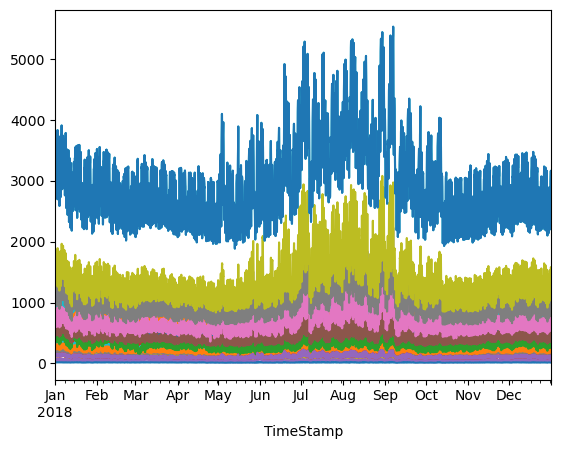

In [5]:
bus_demand_2018.plot(legend=False)

## 2. NYISO 2023-2042 Outlook

In [6]:
zone_name2id = {
    'WEST': 'A', 'GENESEE': 'B', 'CENTRAL': 'C', 'NORTH': 'D',
    'MOHAWK VALLEY': 'E', 'CAPITAL': 'F', 'HUDSON VALLEY': 'G',
    'MILLWOOD': 'H', 'DUNWOODIE': 'I', 'NYC': 'J', 'L ISLAND': 'K'
}

In [9]:
def process_load_2bus(zonal_load, bus_info):

    # Rename 'Period' to 'Hour' and get TimeStamp from Year, Month, Day, Hour
    zonal_load = zonal_load.rename(columns={'Period': 'Hour'})
    # Set hour begins from 0
    zonal_load['Hour'] = zonal_load['Hour'] - 1
    zonal_load['TimeStamp'] = pd.to_datetime(
        zonal_load[['Year', 'Month', 'Day', 'Hour']])
    zonal_load = zonal_load.drop(
        columns=['Year', 'Month', 'Day', 'Hour'])
    zonal_load = zonal_load.set_index('TimeStamp')

    # Get data for model year: 2030
    zonal_load_2030 = zonal_load[zonal_load.index.year == 2030].copy()

    # Distribute load to buses
    bus_load_2030 = ng_prep.add_load_weighted(zonal_load_2030, bus_info)

    # Get data for model year: 2040
    zonal_load_2040 = zonal_load[zonal_load.index.year == 2040].copy()

    # Distribute load to buses
    bus_load_2040 = ng_prep.add_load_weighted(zonal_load_2040, bus_info)

    return bus_load_2030, bus_load_2040

### 2.1. Baseline

In [10]:
filename = '/mnt/Bo_HDD/NYgrid-python/data/renewable/2023-2042-System-Resource-Outlook-Forecasts.xlsx'
zonal_load_baseline = pd.read_excel(
    filename, sheet_name='Load_Baseline', header=1, usecols='A:O')
zonal_load_baseline = zonal_load_baseline.rename(columns=zone_name2id)

# Distribute load to buses
bus_load_baseline_2030, bus_load_baseline_2040 = process_load_2bus(
    zonal_load_baseline, bus_info=bus_info)

### 2.2 Lower Demand Policy

In [11]:
filename = '/mnt/Bo_HDD/NYgrid-python/data/renewable/2023-2042-System-Resource-Outlook-Forecasts.xlsx'
zonal_load_lower_demand = pd.read_excel(
    filename, sheet_name='Load_LowerDemandPolicy', header=1, usecols='A:O')
zonal_load_lower_demand = zonal_load_lower_demand.rename(columns=zone_name2id)

# Distribute load to buses
bus_load_lower_demand_2030, bus_load_lower_demand_2040 = process_load_2bus(
    zonal_load_lower_demand, bus_info=bus_info)

### 2.3. Higher Demand Policy

In [12]:
filename = '/mnt/Bo_HDD/NYgrid-python/data/renewable/2023-2042-System-Resource-Outlook-Forecasts.xlsx'
zonal_load_higher_demand = pd.read_excel(
    filename, sheet_name='Load_HigherDemandPolicy', header=1, usecols='A:O')
zonal_load_higher_demand = zonal_load_higher_demand.rename(
    columns=zone_name2id)

# Distribute load to buses
bus_load_higher_demand_2030, bus_load_higher_demand_2040 = process_load_2bus(
    zonal_load_higher_demand, bus_info=bus_info)

### 2.4. State Scenario Policy

In [13]:
filename = '/mnt/Bo_HDD/NYgrid-python/data/renewable/2023-2042-System-Resource-Outlook-Forecasts.xlsx'
zonal_load_state_scenario = pd.read_excel(
    filename, sheet_name='Load_StateScenario_Policy', header=1, usecols='A:O')
zonal_load_state_scenario = zonal_load_state_scenario.rename(
    columns=zone_name2id)

# Distribute load to buses
bus_load_state_scenario_2030, bus_load_state_scenario_2040 = process_load_2bus(
    zonal_load_state_scenario, bus_info=bus_info)

### 2.5. Comparison

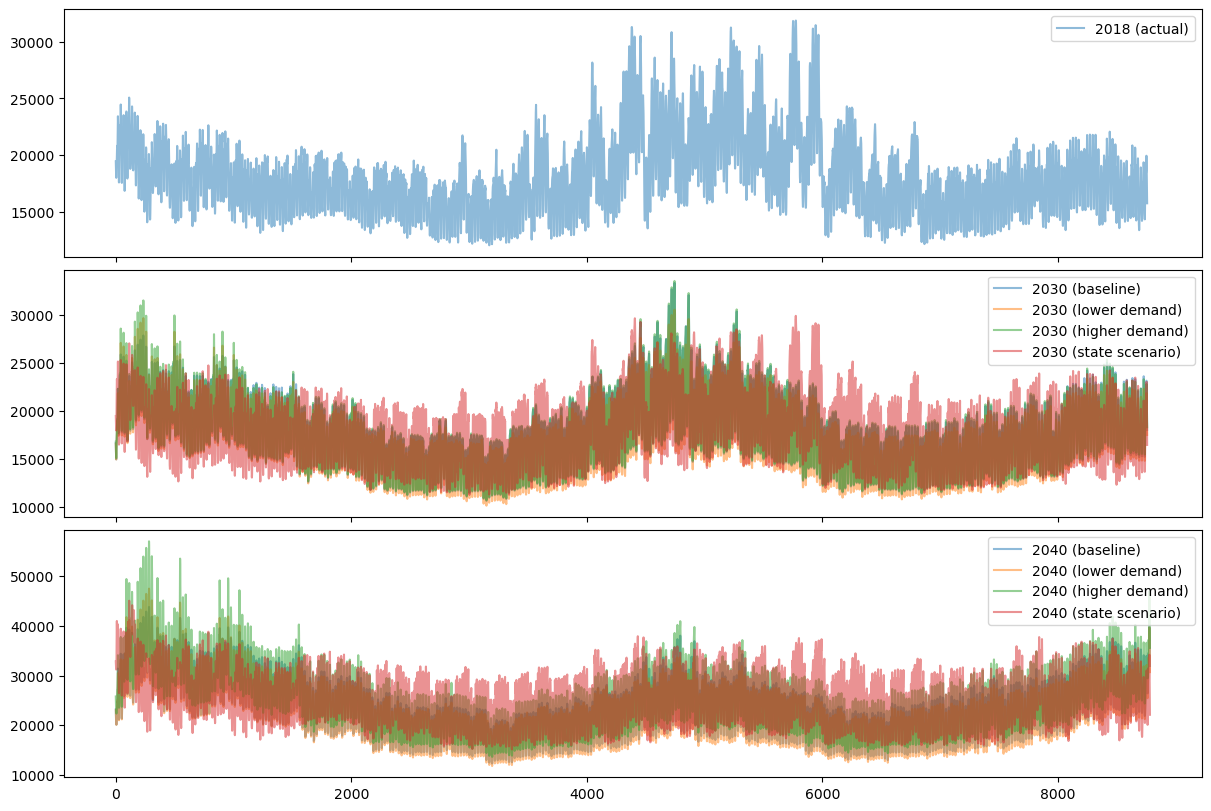

In [14]:
fig, axs = plt.subplots(3, figsize=(12, 8), layout='constrained',
                        sharex=True)
axs[0].plot(range(len(bus_demand_2018)),
            bus_demand_2018.sum(axis=1), label='2018 (actual)', alpha=0.5)
axs[1].plot(range(len(bus_load_baseline_2030)),
            bus_load_baseline_2030.sum(axis=1), label='2030 (baseline)', alpha=0.5)
axs[2].plot(range(len(bus_load_baseline_2040)),
            bus_load_baseline_2040.sum(axis=1), label='2040 (baseline)', alpha=0.5)
axs[1].plot(range(len(bus_load_lower_demand_2030)),
            bus_load_lower_demand_2030.sum(axis=1), label='2030 (lower demand)', alpha=0.5)
axs[2].plot(range(len(bus_load_lower_demand_2040)),
            bus_load_lower_demand_2040.sum(axis=1), label='2040 (lower demand)', alpha=0.5)
axs[1].plot(range(len(bus_load_higher_demand_2030)),
            bus_load_higher_demand_2030.sum(axis=1), label='2030 (higher demand)', alpha=0.5)
axs[2].plot(range(len(bus_load_higher_demand_2040)),
            bus_load_higher_demand_2040.sum(axis=1), label='2040 (higher demand)', alpha=0.5)
axs[1].plot(range(len(bus_load_state_scenario_2030)),
            bus_load_state_scenario_2030.sum(axis=1), label='2030 (state scenario)', alpha=0.5)
axs[2].plot(range(len(bus_load_state_scenario_2040)),
            bus_load_state_scenario_2040.sum(axis=1), label='2040 (state scenario)', alpha=0.5)

for ax in axs:
    ax.legend(loc='upper right')
plt.show()

### 2.6. Save the data

In [15]:
output_dir = '/mnt/Bo_HDD/NYgrid-python/data/load/nyiso_2023-2042_outlook'
os.makedirs(output_dir, exist_ok=True)
bus_demand_2018.to_csv(f'{output_dir}/bus_demand_2018.csv')
bus_load_baseline_2030.to_csv(f'{output_dir}/bus_load_baseline_2030.csv')
bus_load_baseline_2040.to_csv(f'{output_dir}/bus_load_baseline_2040.csv')
bus_load_lower_demand_2030.to_csv(
    f'{output_dir}/bus_load_lower_demand_2030.csv')
bus_load_lower_demand_2040.to_csv(
    f'{output_dir}/bus_load_lower_demand_2040.csv')
bus_load_higher_demand_2030.to_csv(
    f'{output_dir}/bus_load_higher_demand_2030.csv')
bus_load_higher_demand_2040.to_csv(
    f'{output_dir}/bus_load_higher_demand_2040.csv')
bus_load_state_scenario_2030.to_csv(
    f'{output_dir}/bus_load_state_scenario_2030.csv')
bus_load_state_scenario_2040.to_csv(
    f'{output_dir}/bus_load_state_scenario_2040.csv')

## 3. NYISO historical demand (2002-2020)

In [24]:
# Read load data: 2002-2020
filename = '/media/by276/Bo_SSD/offshore_wind/Data/Demand/demand_base_zone.csv'
zonal_demand = pd.read_csv(filename, index_col=0, parse_dates=True)

# Replace negative values with 0
zonal_demand[zonal_demand < 0] = 0

In [25]:
# Distribute load to buses
sample_hour_load = ng_prep.add_load_weighted(zonal_demand, bus_info=bus_info)
sample_hour_load

,39,41,42,45,46,47,49,51,52,53,...,73,74,75,76,77,78,79,80,81,82
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,238.60000,977.765108,247.234892,262.978934,23.627014,542.394052,762.0000,854.802198,216.971831,810.028169,...,238.60000,264.0000,119.30000,119.30000,477.20000,491.0000,931.942092,1242.589456,2680.234226,2680.234226
2002-01-01 01:00:00,223.40000,927.480046,234.519954,248.386617,22.315985,512.297398,758.0000,781.087912,207.887324,776.112676,...,223.40000,244.0000,111.70000,111.70000,446.80000,453.0000,879.208309,1172.277746,2536.256972,2536.256972
2002-01-01 02:00:00,212.00000,885.974914,224.025086,236.014870,21.204461,486.780669,750.0000,714.934066,197.535211,737.464789,...,212.00000,223.0000,106.00000,106.00000,424.00000,431.0000,830.020593,1106.694125,2393.142641,2393.142641
2002-01-01 03:00:00,206.20000,878.791334,222.208666,228.401487,20.520446,471.078067,748.0000,709.263736,190.985915,713.014085,...,206.20000,217.0000,103.10000,103.10000,412.40000,422.0000,800.447044,1067.262725,2301.145116,2301.145116
2002-01-01 04:00:00,205.40000,881.984036,223.015964,229.987608,20.662949,474.349442,748.0000,705.483516,191.197183,713.802817,...,205.40000,215.0000,102.70000,102.70000,410.80000,404.0000,790.639015,1054.185354,2253.087816,2253.087816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,246.55620,1207.734025,305.384175,325.687736,29.261008,671.730956,675.9467,915.283682,250.582331,935.507369,...,246.55620,411.9453,123.27810,123.27810,493.11240,715.7587,1119.283543,1492.378057,2860.656450,2860.656450
2020-12-31 20:00:00,237.66788,1162.988860,294.070040,316.575088,28.442293,652.936119,665.3796,885.863933,242.140690,903.991910,...,237.66788,393.8276,118.83394,118.83394,475.33576,692.8507,1074.040500,1432.054000,2771.675750,2771.675750
2020-12-31 21:00:00,229.32270,1112.474401,281.297099,302.428407,27.171302,623.758590,653.3130,864.251424,233.139148,870.386152,...,229.32270,370.6922,114.66135,114.66135,458.64540,671.4122,1027.572729,1370.096971,2684.491850,2684.491850


<Axes: xlabel='TimeStamp'>

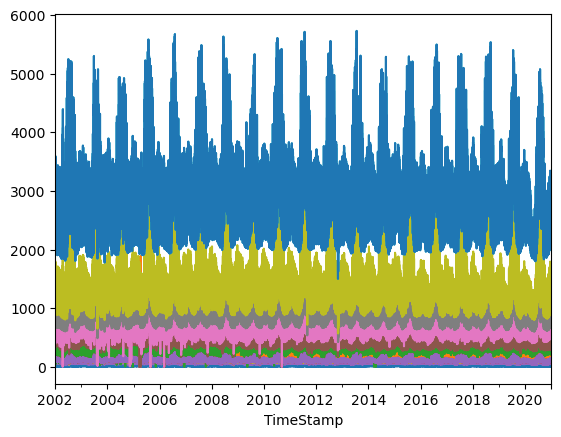

In [26]:
sample_hour_load.plot(legend=False)

In [27]:
sample_hour_load.to_csv('/media/by276/Bo_SSD/offshore_wind/Data/Demand/demand_base_bus.csv')